<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO obtain data from ESO catalogues

The ESO catalogue facility provides access to the collection of data that were produced by PIs of ESO programmes and then integrated into the ESO science archive through the Phase 3 process. 

The full list of available cataolgues could be found [here](https://www.eso.org/qi/).

To access the data you can use the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` TAP Service. 

The module `archive_catalogues` provides some simple `python` wrapper around this. For more details please see the [ESOAsg documentation](https://esoasg.readthedocs.io/en/latest/)

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [1]:
from ESOAsg import archive_catalogues # ESO Archive Catalogues

import matplotlib.pyplot as plt # Matplotlib
import scipy.stats as stats # Scipy Stats
import numpy as np # Numpy

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

---
## <a id='Check catalogue'>1. Check the catalogue you want to query </a>


To begin, you need to know which catalogue you are interested to query. 

If in doubt, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (and all their versions) using:
```python
archive_catalogues.all_catalogues_info(all_versions=True)
```

Note that the column `last_version` highlights with `False` and obsolte catalogue for which a newer version is present. 

It is however possible to remove these obsolete versions by setting:
```python
all_version=False # i.e. the default behavior
```

In [2]:
all_catalogues = archive_catalogues.catalogues_info(all_versions=False) # Get all the available catalogues

Now `all_catalogues` contains information on all the latest versions of the catalogues currently present at ESO:

In [3]:
# Show the available catalogues
all_catalogues['collection', 'table_name', 'title', 'version'].show_in_notebook(show_row_index=False, display_length=100)

collection,table_name,title,version
1101.A-0127,AMUSED_MAIN_SOURCE_CAT_V1,AMUSED: the MUSE Hubble Ultra-Deep Field surveys,1
195.B-0283,GNS_catalogue_V1,GALACTICNUCLEUS Survey,1
196.D-0214,EREBOS_RV_cat_fits_V1,EREBOS_RV_cat.fits,1
196.D-0214,EREBOS_cat_fits_V1,EREBOS_cat.fits,1
AMBRE,AMBRE_HARPS_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra - HARPS,1
AMBRE,AMBRE_UVES_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra - UVES,1
AMBRE,AMBRE_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1
ATLASGAL,ATLASGAL_V1,ATLASGAL - APEX Large Area Survey of the Galaxy,1
FDS,FDS_SourceCatalogue_V1,Fornax Deep Survey Source Catalogue,1
GAIAESO,GES_2021_VRAD,GAIAESO catalogue of radial velocities,1


---
## <a id='Get catalogue'>2. Get a catalogue... </a>


In the following we will consider the [`VIKING version 4`](https://www.eso.org/qi/catalog/show/320) catalogue as an example:
```python
collection = 'VIKING'
table_viking = 'viking_er5_zyjj_1j_2hks_catMetaData_fits_V4'
```
By adding the condition `collections='VIKING'` it is possible to limit the table to the `VIKING` related catalogues only:

In [4]:
viking_catalogue = archive_catalogues.catalogues_info(all_versions=False, collections='VIKING') # Get the VIKING catalogues
viking_catalogue['table_name', 'version', 'last_version', 'table_RA', 'target_table'].show_in_notebook(display_length=10) # Show the VIKING catalogues

idx,table_name,version,last_version,table_RA,target_table
0,viking_er5_zyjj_1j_2hks_catMetaData_fits_V4,4,True,RA2000,


### <a id='Publication info'>2.1 Look at pulication info </a>

This allows to extract information such as `table_name` and `acknowledgment` in a simpler way: 

In [5]:
table_viking = viking_catalogue['table_name'].data[0] # Get the name of the table
acknowledgment_viking = viking_catalogue['acknowledgment'].data[0] # Get the acknowledgment
print('The name of the table is: {}. \nThe corresponding acknowledgment is:\n{}.'.format(table_viking, acknowledgment_viking)) # Print the name of the table and the acknowledgment

The name of the table is: viking_er5_zyjj_1j_2hks_catMetaData_fits_V4. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any published material that makes use of this data products: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories under programme ID(s) 179.A-2004(M).


### <a id='Content info'>2.2 Look at content info </a>

You can glance the content of a catalogue by checking the name of the columns present in the associated list of collections (or list of tables):
```python
archive_catalogues.columns_info(collections='VIKING')
```

In [6]:
columns_viking = archive_catalogues.columns_info(collections='VIKING') # Get the columns of the VIKING catalogues
columns_viking.show_in_notebook(show_row_index=False) # Show the columns of the VIKING catalogues

table_name,column_name,ucd,datatype,description,unit
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,IAUNAME,meta.id,CHAR,IAU Name (not unique),
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,SOURCEID,meta.id;meta.main,BIGINT,UID of this merged detection as assigned by merge algorithm,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,CUEVENTID,meta.bib,INTEGER,UID of curation event giving rise to this record,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,FRAMESETID,meta.bib,BIGINT,UID of the set of frames that this merged source comes from,
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,RA2000,pos.eq.ra;meta.main,DOUBLE,Celestial Right Ascension,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,DEC2000,pos.eq.dec;meta.main,DOUBLE,Celestial Declination,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,L,pos.galactic.lon,DOUBLE,Galactic longitude,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,B,pos.galactic.lat,DOUBLE,Galactic latitude,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,LAMBDA,pos,DOUBLE,SDSS system spherical co-ordinate 1,Degrees
viking_er4_zyjj_1j_2hks_catMetaData_fits_V3,ETA,pos,DOUBLE,SDSS system spherical co-ordinate 2,Degrees


### <a id='Download catalogues'>2.3 Download catalogues </a>

Once you decided which is your favourite catalogue, you can get it using:
```python
archive_catalogues.get_catalogues(tables=table_name)
```
At the moment with limit the query to only 2 entries `VIKING` (i.e. we set `maxrec=2`):

In [7]:
viking = archive_catalogues.get_catalogues(tables=table_viking, maxrec=2) # Get the VIKING catalogues

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/pyvo/dal/query.py:322: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",
[INFO]    :: The query to viking_er5_zyjj_1j_2hks_catMetaData_fits_V4 returned 2 entries (with a limit set to maxrec=2)


The result is thus stored in an `astropy.table`:

In [8]:
viking['SOURCEID', 'RA2000', 'DEC2000', 'ZAPERMAG3', 'JAPERMAG3', 'KSAPERMAG3'].show_in_notebook(show_row_index=False, display_length=10) # Show the first 10 rows of the VIKING catalogues

SOURCEID,RA2000,DEC2000,ZAPERMAG3,JAPERMAG3,KSAPERMAG3
,deg,deg,mag,mag,mag
601300528653,359.67993857482685,-33.763130074618424,19.39489,18.642626,17.30067
601300528654,359.67432240361,-34.493249400435296,22.311148,--,19.311176


---
## <a id='Explore data'>3. Explore the data... </a>

Now the `VIKING V4` catalogue is ready to be explored. As an example, we queried a larger fraction of the catalogue to show the color-color diagram for stars (in blue) and extended sources (red). 

Note that, to speed up the process: 

* we queried the table for only the columns we are interested in, i.e. 'MERGEDCLASS', 'ZAPERMAG3', 'JAPERMAG3', and 'KSAPERMAG3'
* we also opted for an `asynchronous` query -- TODO! 

### <a id='Get stars'>3.1 Get Stars and properties </a>

In [9]:
selected_columns = ['MERGEDCLASS', 'ZAPERMAG3', 'JAPERMAG3', 'KSAPERMAG3'] # Select the columns to be retrieved

viking = archive_catalogues.get_catalogues(tables=table_viking, columns=selected_columns, maxrec=10000, type_of_query='sync') # Get the VIKING catalogues

class_star = viking['MERGEDCLASS'].data # Class star
jk = viking['JAPERMAG3'].data - viking['KSAPERMAG3'].data # J-K
zj = viking['ZAPERMAG3'].data - viking['JAPERMAG3'].data # Z-J

# Mask the data to remove the masked values
masked_data = [~jk.mask & ~zj.mask][0] 
class_star = class_star.data[masked_data]
jk = jk.data[masked_data]
zj = zj.data[masked_data]

[INFO]    :: The query to viking_er5_zyjj_1j_2hks_catMetaData_fits_V4 returned 10000 entries (with a limit set to maxrec=10000)


### <a id='Plot properties'>3.2 Plot colour-colour plots </a>

Here we plot the following.

1) Scatter plot of the `J-K` vs `Z-J` values 
2) Kernal density estimate of the `J-K` vs `Z-J` values

Given the large number of datapoints, the latter can be prefered... 

But also see example of `example05_HOWTO_compareCatalogues.ipynb` for alternative plotting method.

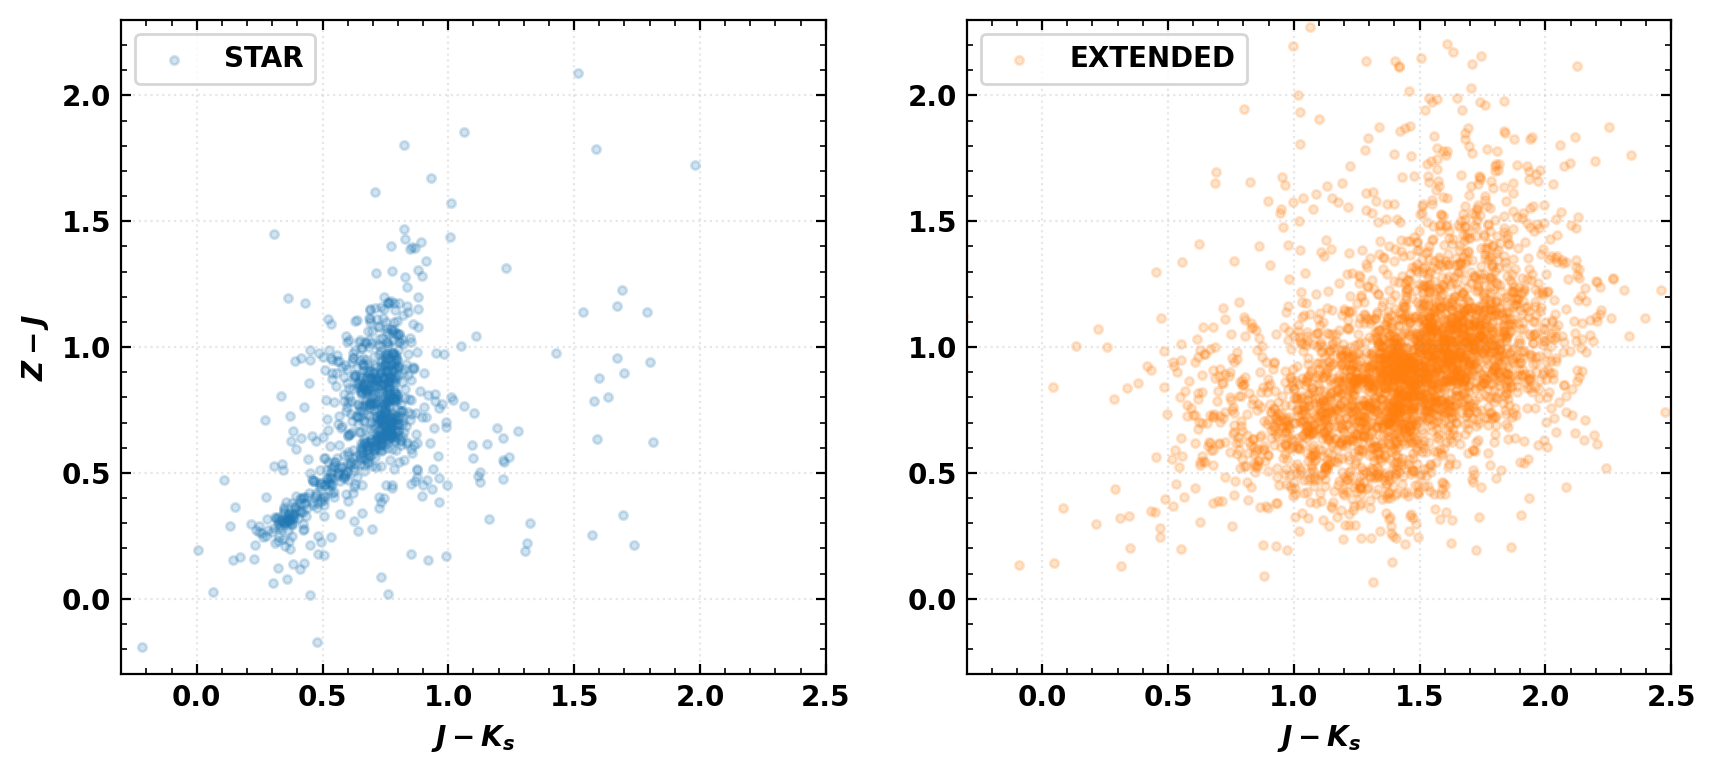

In [10]:
# Create a figure with a specific size
fig = plt.figure(figsize=(10, 7))

# Create two subplots side-by-side (1 row, 2 columns)
ax1 = fig.add_subplot(121)  # Left subplot
ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)  # Right subplot with shared x and y axes

# Set the aspect ratio of both subplots to 'equal' for proportional axes
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Create a mask to filter stars (class_star == -1)
mask_star = class_star == -1

# Plot scatter points for stars on the left subplot
ax1.scatter(
    jk[mask_star],  # J-K values for stars
    zj[mask_star],  # Z-J values for stars
    label=r'STAR',  # Label for the legend
    c='C0',  # Color of the points
    alpha=0.2,  # Transparency level
    marker='.'  # Point marker style
)

# Plot scatter points for extended objects (not stars) on the right subplot
ax2.scatter(
    jk[~mask_star],  # J-K values for extended objects
    zj[~mask_star],  # Z-J values for extended objects
    label=r'EXTENDED',  # Label for the legend
    c='C1',  # Color of the points
    alpha=0.2,  # Transparency level
    marker='.'  # Point marker style
)

# Set common properties for both subplots
for ax in [ax1, ax2]:
    ax.set_xlim(-0.3, 2.5)  # Set x-axis limits
    ax.set_ylim(-0.3, 2.3)  # Set y-axis limits
    ax.set_xlabel(r'$J - K_s$')  # Set x-axis label
    ax.legend(loc='upper left')  # Add legend at the upper left corner
    ax.grid(True, ls=':', alpha=0.3) # Add a grid with dashed lines

# Set the y-axis label only for the left subplot
ax1.set_ylabel(r'$Z - J$')

# Save the figure as a high-quality JPG file with tight bounding box
fig.savefig('./figures/viking.png', format='png', bbox_inches='tight')

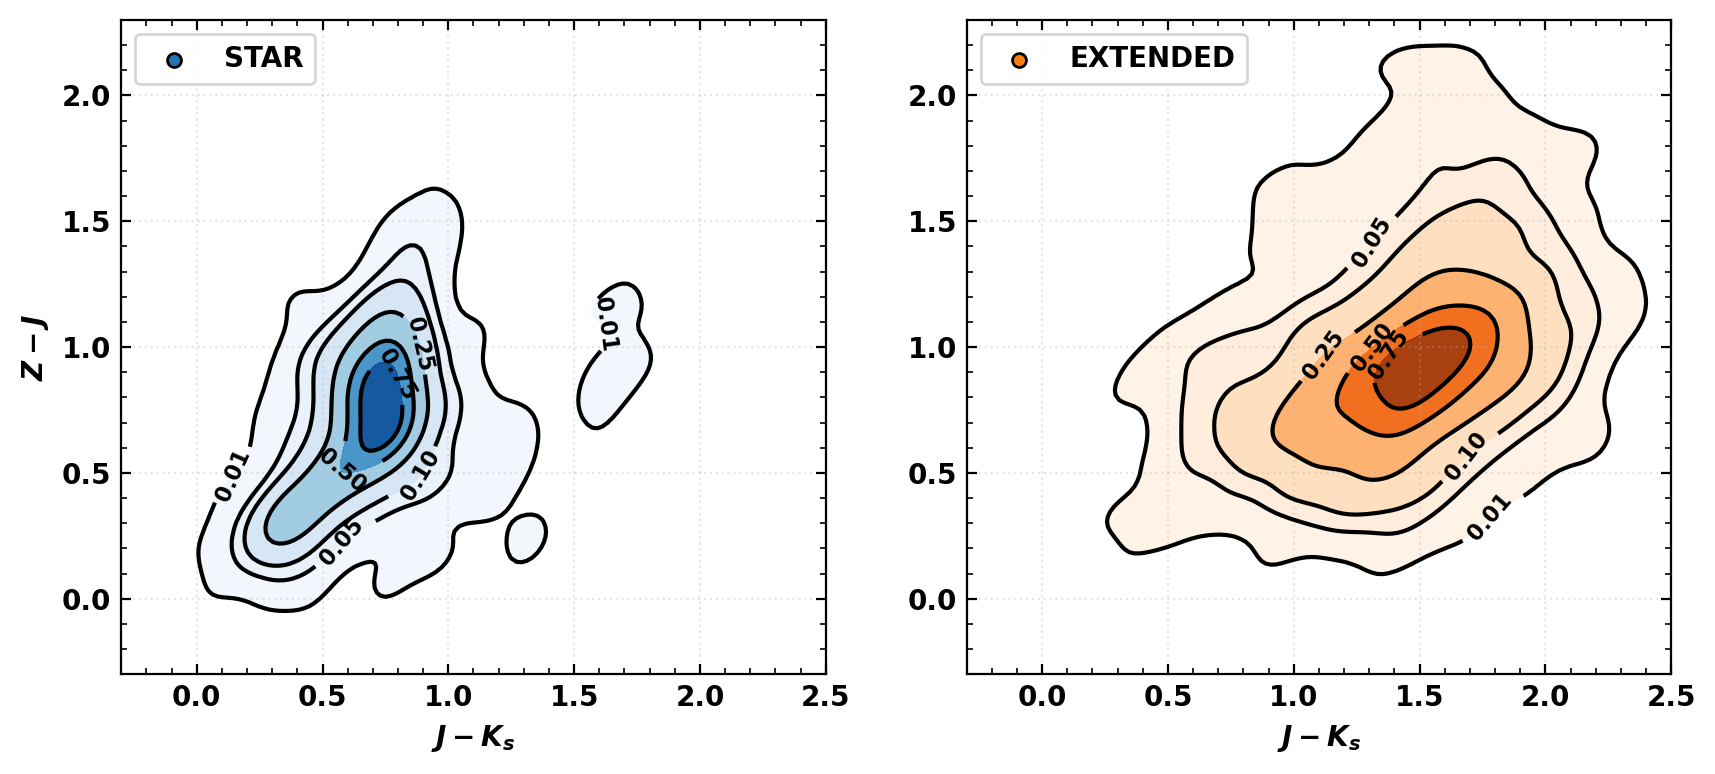

In [11]:
# Define a function to perform and plot kernel density estimation (KDE)
def plot_kde(ax, x, y, xmin, xmax, ymin, ymax, cmap='Blues'):
    """
    Generate KDE contours on the provided axes.

    Parameters:
        ax: Matplotlib axis to plot on.
        x, y: Data for the KDE (1D arrays).
        xmin, xmax, ymin, ymax: Bounds for the KDE grid.
        cmap: Colormap for filled contours.

    Returns:
        ax: Matplotlib axis with contours plotted.
    """
    # Create a grid for evaluating the KDE
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    # Perform KDE using scipy's gaussian_kde
    kernel = stats.gaussian_kde(values)
    kde = np.reshape(kernel(positions).T, xx.shape)
    kde = kde / np.max(kde)  # Normalize the KDE for consistent contour levels

    # Define contour levels
    levels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
    
    # Plot filled contours
    cfset = ax.contourf(xx, yy, kde, levels=levels, cmap=cmap, vmin=0, alpha=0.95)
    # Plot contour lines
    cset = ax.contour(xx, yy, kde, levels=levels, colors='k')
    # Add labels to contour lines
    ax.clabel(cset, inline=1, fontsize=8)

    return ax

# Create a figure with specified size
fig = plt.figure(figsize=(10, 7))

# Create two subplots side-by-side (1 row, 2 columns)
ax1 = fig.add_subplot(121)  # Left subplot
ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)  # Right subplot with shared x and y axes

# Set aspect ratio for both subplots to 'equal' for proportional axes
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Boolean mask for selecting star and extended object data
mask_star = class_star == -1

# Plot KDE for stars on the left subplot
ax1 = plot_kde(ax1, jk[mask_star], zj[mask_star], xmin=-1, xmax=3, ymin=-1, ymax=3, cmap='Blues')

# Plot KDE for extended objects on the right subplot
ax2 = plot_kde(ax2, jk[~mask_star], zj[~mask_star], xmin=-1, xmax=3, ymin=-1, ymax=3, cmap='Oranges')

# Add dummy scatter points to create a legend (actual scatter points are not plotted)
ax1.scatter(np.nan, np.nan, label=r'STAR', fc='C0', ec='k', marker='.', s=100)
ax2.scatter(np.nan, np.nan, label=r'EXTENDED', fc='C1',  ec='k', marker='.', s=100)

# Set common properties for both subplots
for ax in [ax1, ax2]:
    ax.set_xlim(-0.3, 2.5)  # Set x-axis limits
    ax.set_ylim(-0.3, 2.3)  # Set y-axis limits
    ax.set_xlabel(r'$J - K_s$')  # Set x-axis label
    ax.legend(loc='upper left')  # Add legend at the upper left corner
    ax.grid(True, ls=':', alpha=0.3) # Add a grid with dashed lines

# Set the y-axis label for the left subplot only
ax1.set_ylabel(r'$Z - J$')

# Save the figure to a file in high quality with tight bounding box
fig.savefig('./figures/viking_kde.png', format='png', bbox_inches='tight')